<a href="https://colab.research.google.com/github/DoitDigital-lab/Calculadora/blob/main/PocoVidNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.append('/content/drive/My Drive/full_path')
sys.path.append('/content/drive/MyDrive/Pocovid/pocovidnet/')

In [4]:
import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from imutils import paths
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from pocovidnet import MODEL_FACTORY
from pocovidnet.utils import Metrics
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


In [ ]:
# Suppress logging
tf.get_logger().setLevel('ERROR')


# Initialize hyperparameters
DATA_DIR = "/content/drive/MyDrive/Pocovid/data/cross_validation/"
#DATA_DIR = "/content/drive/MyDrive/Pocovid/data/SuperC/"
MODEL_NAME = "test11"
FOLD = "2"
MODEL_DIR = os.path.join('models/', MODEL_NAME, f'fold_2')
LR = 1e-4
EPOCHS = 30
BATCH_SIZE = 32
MODEL_ID = "vgg_base"
TRAINABLE_BASE_LAYERS = 1
IMG_WIDTH, IMG_HEIGHT = 224, 224
LOG_SOFTMAX = True
HIDDEN_SIZE = 64

# Check if model class exists
if MODEL_ID not in MODEL_FACTORY.keys():
    raise ValueError(
        f'Model {MODEL_ID} not implemented. Choose from {MODEL_FACTORY.keys()}'
    )

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print('Loading images...')
imagePaths = list(paths.list_images(DATA_DIR))
data = []
labels = []

print(f'selected fold: {FOLD}')

train_labels, test_labels = [], []
train_data, test_data = [], []
# test_files = []

# loop over folds
for imagePath in imagePaths:

    path_parts = imagePath.split(os.path.sep)
    #extract the split
    train_test = path_parts[-3][-1]
    # extract the class label from the filename
    label = path_parts[-2]
   
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    R, G, B = cv2.split(image)
    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)
    image = cv2.merge((output1_R, output1_G, output1_B))
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
   
    if train_test == str(FOLD):
        test_labels.append(label)
        test_data.append(image)
        # test_files.append(path_parts[-1])
    else:
        train_labels.append(label)
        train_data.append(image)

# Prepare data for model
print(
    f'\nNumber of training samples: {len(train_labels)} \n'
    f'Number of testing samples: {len(test_labels)}'
)

assert len(set(train_labels)) == len(set(test_labels)), (
    'Something went wrong. Some classes are only in train or test data.'
)  # yapf: disable

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]

#X_train_old=X_train
#X_test_old=X_test
min_max_scaler = preprocessing.MinMaxScaler()

train_data = np.array(train_data) / 255.0
test_data = np.array(test_data) / 255.0
train_labels_text = np.array(train_labels)
test_labels_text = np.array(test_labels)

train_data = min_max_scaler.fit_transform(train_data)
test_data = min_max_scaler.transform(test_data)

num_classes = len(set(train_labels))

# perform one-hot encoding on the labels
lb = LabelBinarizer()
lb.fit(train_labels_text)

train_labels = lb.transform(train_labels_text)
test_labels = lb.transform(test_labels_text)

if num_classes == 2:
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    test_labels = to_categorical(test_labels, num_classes=num_classes)

trainX = train_data
trainY = train_labels
testX = test_data
testY = test_labels
print('Class mappings are:', lb.classes_)


trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Load the VGG16 network
print('Compiling VGG16...')
model = MODEL_FACTORY[MODEL_ID](
    input_size=(IMG_WIDTH, IMG_HEIGHT, 3),
    num_classes=num_classes,
    trainable_layers=TRAINABLE_BASE_LAYERS,
    log_softmax=LOG_SOFTMAX,
    hidden_size=HIDDEN_SIZE
)

# Define callbacks


earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=1,
    mode='min',
    restore_best_weights=True
)



#os.path.join(MODEL_DIR, 'fold_' + str(FOLD) + '_epoch_{epoch:02d}'),

mcp_save = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'best_weights'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=30,
    verbose=1,
    epsilon=1e-4,
    mode='min'
)



Loading images...
selected fold: 2


Compiling model...
Model has 14747971 parameters
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_poo

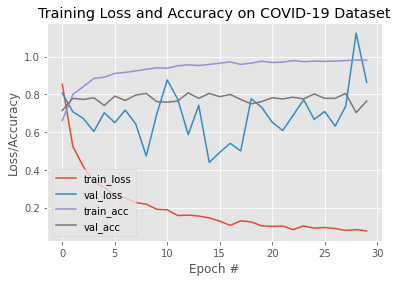

In [ ]:
# To show balanced accuracy
metrics = Metrics((testX, testY), model)

# compile model
print('Compiling model...')
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)
loss = (
    tf.keras.losses.CategoricalCrossentropy() if not LOG_SOFTMAX else (
        lambda labels, targets: tf.reduce_mean(
            tf.reduce_sum(
                -1 * tf.math.multiply(tf.cast(labels, tf.float32), targets),
                axis=1
            )
        )
    )
)
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

print(f'Model has {model.count_params()} parameters')
print(f'Model summary {model.summary()}')

# train the head of the network
print('Starting training model...')
#H = model.fit_generator(
#trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
#steps_per_epoch=len(trainX) // BATCH_SIZE,
#validation_data=(testX, testY),
#validation_steps=len(testX) // BATCH_SIZE,
#epochs=EPOCHS,
#callbacks=[earlyStopping, mcp_save, reduce_lr_loss, metrics]
#)
H = model.fit(trainAug.flow(x=trainX, y=trainY, batch_size=BATCH_SIZE),
          epochs=EPOCHS,
          validation_data=(testX, testY),
          steps_per_epoch=len(trainX) // BATCH_SIZE,
          validation_steps=len(testX) // BATCH_SIZE,
          callbacks = [earlyStopping, mcp_save, reduce_lr_loss, metrics])

#callbacks = [earlyStopping, mcp_save, reduce_lr_loss, metrics]

# make predictions on the testing set
print('Evaluating network...')
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)

# CSV: save predictions for inspection:
df = pd.DataFrame(predIdxs)
df.to_csv(os.path.join(MODEL_DIR, "_preds_last_epoch.csv"))

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print('classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
print('confusion matrix:')
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
#print(predIdxs)

# plot the training loss and accuracy
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy on COVID-19 Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig(os.path.join(MODEL_DIR, 'loss.png'))
print('Done, shuttting down!')
